
# Naive CNN Grid Detector — with Precision / Recall / F1

- 데이터: `1-1_training_X/` (이미지), `1-1_training_Y/` (JSON 라벨)  
- 모델: **Naive CNN**  
- 개선:  
  - `objectness`는 **logits** 출력 + `BCEWithLogitsLoss` 사용 (학습 안정)  
  - `noobj_weight` 축소, 간단 NMS, 학습률/에폭 기본값 조정  
  - **Precision / Recall / F1**를 에폭마다 계산/출력


In [1]:
from pathlib import Path

BASE = Path(".")  # 데이터가 있는 최상위 폴더 (필요하면 바꾸세요)

def list_pairs(img_dir: Path, lbl_dir: Path, exts=(".png", ".jpg", ".jpeg", ".bmp")):
    pairs = []
    for ip in img_dir.iterdir():
        if ip.suffix.lower() in exts:
            jp = lbl_dir / f"{ip.stem}.json"
            if jp.exists():
                pairs.append((str(ip), str(jp)))
    return pairs

# 모든 training_* 세트 모으기
train_dirs = sorted([p for p in BASE.iterdir() if p.is_dir() and p.name.endswith("_training_X")])
train_pairs = []
for img_dir in train_dirs:
    lbl_dir = BASE / img_dir.name.replace("_training_X", "_training_Y")
    if lbl_dir.exists():
        train_pairs += list_pairs(img_dir, lbl_dir)

print(f"[TRAIN] 폴더 수: {len(train_dirs)} | 페어 수: {len(train_pairs):,}")

# 모든 val_* 세트 모으기 (있으면 검증에 사용)
val_dirs = sorted([p for p in BASE.iterdir() if p.is_dir() and p.name.endswith("_val_X")])
val_pairs = []
for img_dir in val_dirs:
    lbl_dir = BASE / img_dir.name.replace("_val_X", "_val_Y")
    if lbl_dir.exists():
        val_pairs += list_pairs(img_dir, lbl_dir)

print(f"[VAL]   폴더 수: {len(val_dirs)} | 페어 수: {len(val_pairs):,}")


[TRAIN] 폴더 수: 5 | 페어 수: 7,984
[VAL]   폴더 수: 5 | 페어 수: 997


In [25]:
# 0) pairs 수집 (파일명 기준 .png <-> .json)
from pathlib import Path
BASE = Path("."); IMG_EXT=".png"; LBL_EXT=".json"

def collect_pairs(x_suffix, y_suffix):
    pairs=[]; x_dirs=sorted([p for p in BASE.iterdir() if p.is_dir() and p.name.endswith(x_suffix)])
    for xdir in x_dirs:
        ydir = BASE / xdir.name.replace(x_suffix, y_suffix)
        if not ydir.exists(): continue
        for ip in xdir.rglob(f"*{IMG_EXT}"):
            jp = ydir / f"{ip.stem}{LBL_EXT}"
            if jp.exists(): pairs.append((str(ip), str(jp)))
    return pairs

train_pairs = collect_pairs("_training_X","_training_Y")
val_pairs   = collect_pairs("_val_X","_val_Y")

# 1) === 여기부터 당신이 올린 OCRGridDataset 블록 그대로 ===
import random
random.seed(0)

from typing import List, Tuple
import json
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import torch.nn.functional as F

class OCRGridDataset(Dataset):
    def __init__(self, pairs, img_size=640, S=16, gaussian_radius=1):
        self.pairs = pairs; self.img_size = img_size; self.S = S; self.r = gaussian_radius
        self.tf = T.Compose([T.Resize((img_size, img_size)), T.ToTensor()])
    def __len__(self): return len(self.pairs)
    def _load_boxes(self, json_path):
        with open(json_path, "r", encoding="utf-8") as f: data = json.load(f)
        boxes = (data.get("boxes") or data.get("bboxes") or data.get("annotations") or []) if isinstance(data, dict) else data
        out=[]
        for b in boxes:
            x,y,w,h = b.get("x"), b.get("y"), b.get("w"), b.get("h")
            if None in (x,y,w,h): continue
            out.append({"x":float(x),"y":float(y),"w":float(w),"h":float(h)})
        return out
    def _to_grid_targets(self, boxes):
        S=self.S; r=self.r
        heat=torch.zeros((1,S,S)); off=torch.zeros((2,S,S)); size=torch.zeros((2,S,S)); mask=torch.zeros((1,S,S))
        for b in boxes:
            cx,cy,w,h=b["x"],b["y"],b["w"],b["h"]
            if max(cx,cy,w,h)>1.0:
                cx/=self.img_size; cy/=self.img_size; w/=self.img_size; h/=self.img_size
            gx,gy=cx*S,cy*S; ix,iy=int(gx),int(gy)
            if not(0<=ix<S and 0<=iy<S): continue
            for dx in range(-r,r+1):
                for dy in range(-r,r+1):
                    x=ix+dx; y=iy+dy
                    if 0<=x<S and 0<=y<S:
                        d2=dx*dx+dy*dy
                        val=torch.exp(torch.tensor(-0.5*(d2/max(1e-6,r*r))))
                        heat[0,y,x]=max(heat[0,y,x],val)
            fx,fy=gx-ix,gy-iy; off[0,iy,ix]=fx; off[1,iy,ix]=fy
            size[0,iy,ix]=float(min(max(w,1e-6),1.0)); size[1,iy,ix]=float(min(max(h,1e-6),1.0))
            mask[0,iy,ix]=1.0
        return torch.cat([heat,off,size,mask],dim=0)
    def __getitem__(self, idx):
        img_path,json_path=self.pairs[idx]
        img=Image.open(img_path).convert("RGB"); img=self.tf(img)
        target=self._to_grid_targets(self._load_boxes(json_path))
        return img,target

def collate_fn(batch):
    imgs,tgts=zip(*batch)
    return torch.stack(imgs,0), torch.stack(tgts,0)

# val 없으면 9:1 분리
if len(val_pairs)==0:
    random.shuffle(train_pairs); split=int(len(train_pairs)*0.9)
    train_pairs, val_pairs = train_pairs[:split], train_pairs[split:]

IMG_SIZE=640; S=16
train_ds=OCRGridDataset(train_pairs, IMG_SIZE, S)
val_ds  =OCRGridDataset(val_pairs,   IMG_SIZE, S)

# 중요: macOS 3.13 이슈 회피
train_loader=DataLoader(train_ds,batch_size=min(4,max(1,len(train_ds))),shuffle=True, collate_fn=collate_fn, num_workers=0)
val_loader  =DataLoader(val_ds,  batch_size=1,                      shuffle=False, collate_fn=collate_fn, num_workers=0)

print(f"Dataset sizes -> train: {len(train_ds):,}, val: {len(val_ds):,}")


Dataset sizes -> train: 7,984, val: 997


In [26]:
from pathlib import Path

# 노트북이 폴더 바로 안에 있으면 "." 유지, 바깥이라면 Path("DEEP")로 바꾸세요.
BASE = Path(".")

def list_pairs(img_dir, lbl_dir, exts=(".png", ".jpg", ".jpeg", ".bmp")):
    # 문자열이나 Path 모두 허용
    img_dir = Path(img_dir)
    lbl_dir = Path(lbl_dir)
    pairs = []
    for ip in img_dir.iterdir():
        if ip.is_file() and ip.suffix.lower() in exts:
            jp = lbl_dir / f"{ip.stem}.json"
            if jp.exists():
                pairs.append((str(ip), str(jp)))
    # 파일명(stem) 기준 정렬
    pairs.sort(key=lambda x: Path(x[0]).stem)
    return pairs

# --- 모든 training 세트 모으기 ---
train_dirs = sorted([p for p in BASE.iterdir() if p.is_dir() and p.name.endswith("_training_X")])
train_pairs = []
for img_dir in train_dirs:
    lbl_dir = BASE / img_dir.name.replace("_training_X", "_training_Y")
    if lbl_dir.exists():
        train_pairs += list_pairs(img_dir, lbl_dir)

print(f"[TRAIN] 폴더 수: {len(train_dirs)} | 페어 수: {len(train_pairs):,}")
if train_pairs:
    print(train_pairs[:3])

# --- 모든 val 세트 모으기 ---
val_dirs = sorted([p for p in BASE.iterdir() if p.is_dir() and p.name.endswith("_val_X")])
val_pairs = []
for img_dir in val_dirs:
    lbl_dir = BASE / img_dir.name.replace("_val_X", "_val_Y")
    if lbl_dir.exists():
        val_pairs += list_pairs(img_dir, lbl_dir)

print(f"[VAL]   폴더 수: {len(val_dirs)} | 페어 수: {len(val_pairs):,}")
if val_pairs:
    print(val_pairs[:3])


[TRAIN] 폴더 수: 5 | 페어 수: 7,984
[('1-1_training_X/IMG_OCR_6_F_0000102.png', '1-1_training_Y/IMG_OCR_6_F_0000102.json'), ('1-1_training_X/IMG_OCR_6_F_0000202.png', '1-1_training_Y/IMG_OCR_6_F_0000202.json'), ('1-1_training_X/IMG_OCR_6_F_0000302.png', '1-1_training_Y/IMG_OCR_6_F_0000302.json')]
[VAL]   폴더 수: 5 | 페어 수: 997
[('1-1_val_X/IMG_OCR_6_F_0000002.png', '1-1_val_Y/IMG_OCR_6_F_0000002.json'), ('1-1_val_X/IMG_OCR_6_F_0000602.png', '1-1_val_Y/IMG_OCR_6_F_0000602.json'), ('1-1_val_X/IMG_OCR_6_F_0001502.png', '1-1_val_Y/IMG_OCR_6_F_0001502.json')]


In [27]:
from pathlib import Path

BASE = Path(".")
IMG_EXT = ".png"; LBL_EXT = ".json"

def collect_pairs(x_suffix: str, y_suffix: str):
    pairs = []
    x_dirs = sorted([p for p in BASE.iterdir() if p.is_dir() and p.name.endswith(x_suffix)])
    for xdir in x_dirs:
        ydir = BASE / xdir.name.replace(x_suffix, y_suffix)
        if not ydir.exists():
            print(f"[WARN] missing label dir: {ydir}")
            continue
        for ip in xdir.rglob(f"*{IMG_EXT}"):         # 모든 하위폴더 포함
            jp = ydir / f"{ip.stem}{LBL_EXT}"        # 파일명(stem)으로 1:1 매칭
            if jp.exists():
                pairs.append((str(ip), str(jp)))
            else:
                print(f"[WARN] no JSON for {ip}")
    return pairs

train_pairs = collect_pairs("_training_X", "_training_Y")
val_pairs   = collect_pairs("_val_X", "_val_Y")

print(f"[TRAIN] pairs={len(train_pairs):,}")
print(f"[VAL]   pairs={len(val_pairs):,}")


[TRAIN] pairs=7,984
[VAL]   pairs=997


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# === Naive building block: Conv -> BN -> ReLU ===
class ConvBNAct(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=k, stride=s, padding=p, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch)
        self.act  = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

# === A simple stage: (Conv-BN-ReLU)xN -> MaxPool(2x2) ===
class NaiveStage(nn.Module):
    def __init__(self, in_ch, out_ch, num_convs=2, pool=True):
        super().__init__()
        layers = []
        ch_in = in_ch
        for _ in range(num_convs):
            layers.append(ConvBNAct(ch_in, out_ch, k=3, s=1, p=1))
            ch_in = out_ch
        if pool:
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  # downsample by 2
        self.block = nn.Sequential(*layers)
    def forward(self, x):
        return self.block(x)

# === Anchor-free head: outputs 5 channels (heat, dx, dy, w, h) ===
class NaiveCenterNet(nn.Module):
    """
    Pure Conv-BN-ReLU-Pool backbone (no residual, no depthwise).
    Output: [B, 5, S, S]
      - [:,0]  : heat logits (no activation here)
      - [:,1:3]: dx, dy in [0,1] via sigmoid
      - [:,3:5]: w,  h in [0,1] via sigmoid (normalized by image size)
    """
    def __init__(self, S=16, stem_ch=32, width_mult=2.0,
                 convs_per_stage=(1, 1, 2, 2, 2)):
        """
        convs_per_stage: 각 단계에서 Conv-BN-ReLU 반복 횟수
          - 총 5단계(Stem 포함)로 구성하고 매 단계 끝에 MaxPool(2x2)로 downsample
          - 입력 해상도 대비 1/32 특성까지 내려간 뒤, SxS로 보간
        """
        super().__init__()
        self.S = S
        C1 = int(stem_ch)                       # ~32
        C2 = int(stem_ch * width_mult)          # ~64
        C3 = int(stem_ch * width_mult * 2)      # ~128
        C4 = int(stem_ch * width_mult * 3)      # ~192
        C5 = int(stem_ch * width_mult * 4)      # ~256

        # 5개의 stage: (Conv×N) + MaxPool
        self.stage1 = NaiveStage(3,  C1, num_convs=convs_per_stage[0], pool=True)   # /2
        self.stage2 = NaiveStage(C1, C2, num_convs=convs_per_stage[1], pool=True)   # /4
        self.stage3 = NaiveStage(C2, C3, num_convs=convs_per_stage[2], pool=True)   # /8
        self.stage4 = NaiveStage(C3, C4, num_convs=convs_per_stage[3], pool=True)   # /16
        self.stage5 = NaiveStage(C4, C5, num_convs=convs_per_stage[4], pool=True)   # /32

        # Head: 간단한 3x3 -> 1x1
        self.head = nn.Sequential(
            ConvBNAct(C5, C5 // 2, k=3, s=1, p=1),
            nn.Conv2d(C5 // 2, 5, kernel_size=1, stride=1, padding=0)
        )

        # (선택) 간단한 kaiming init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # 다운샘플 경로
        x = self.stage1(x)  # /2
        x = self.stage2(x)  # /4
        x = self.stage3(x)  # /8
        x = self.stage4(x)  # /16
        x = self.stage5(x)  # /32

        # 고정 그리드 크기로 보간
        f = F.interpolate(x, size=(self.S, self.S), mode='bilinear', align_corners=False)

        # 헤드
        out = self.head(f)       # [B,5,S,S]
        heatmap_logit = out[:, 0:1]                  # logits
        offsets       = torch.sigmoid(out[:, 1:3])   # [0,1]
        sizes         = torch.sigmoid(out[:, 3:5])   # [0,1]
        return torch.cat([heatmap_logit, offsets, sizes], dim=1)


In [35]:

# 4) Loss (anchor-free: focal for heatmap, L1 for offsets/sizes on positives)
def focal_loss_logits(logits, targets, alpha=0.25, gamma=2.0):
    # logits: [B,1,S,S], targets: [B,1,S,S] in [0,1]
    prob = torch.sigmoid(logits)
    pos = targets
    neg = 1.0 - targets
    loss_pos = -alpha * (1 - prob)**gamma * torch.log(prob.clamp(min=1e-6)) * pos
    loss_neg = -(1 - alpha) * (prob**gamma) * torch.log((1 - prob).clamp(min=1e-6)) * neg
    return (loss_pos + loss_neg).mean()

def yolo_like_loss(preds, targets, noobj_weight=0.02):
    """
    Compatibility wrapper name; now anchor-free.
    preds: [B,5,S,S] => [heat_logits, dx, dy, w, h]
    targets: [B,6,S,S] => [heat, dx, dy, w, h, mask]
    """
    heat_logit = preds[:,0:1]
    dxdy = preds[:,1:3]
    wh   = preds[:,3:5]

    heat_t = targets[:,0:1]
    off_t  = targets[:,1:3]
    wh_t   = targets[:,3:5]
    mask   = targets[:,5:6]  # 1 at centers

    # Heatmap focal loss
    loss_heat = focal_loss_logits(heat_logit, heat_t)

    # L1 on positives
    pos = mask
    pos_count = pos.sum().clamp(min=1.0)
    loss_off = (torch.abs(dxdy - off_t) * pos).sum() / pos_count
    loss_wh  = (torch.abs(wh   - wh_t)  * pos).sum() / pos_count

    return loss_heat + loss_off + loss_wh


In [36]:

# 5) Decode + NMS
def decode_predictions(pred, conf_th=0.5, topk=200, img_size=640, S=16, iou_th=0.5):
    # pred: [1,5,S,S]
    obj_prob = torch.sigmoid(pred[0,0]).detach().cpu()   # [S,S]
    box = pred[0,1:5].detach().cpu()                     # [4,S,S]

    ys, xs = torch.where(obj_prob > conf_th)
    if ys.numel()==0:
        return torch.zeros((0,4)), torch.zeros((0,))

    scores = obj_prob[ys,xs]
    if scores.numel()>topk:
        vals, idxs = torch.topk(scores, topk)
        ys, xs, scores = ys[idxs], xs[idxs], vals

    bx, by, bw, bh = box[0,ys,xs], box[1,ys,xs], box[2,ys,xs], box[3,ys,xs]
    cx, cy = (xs.float()+bx)/S, (ys.float()+by)/S
    xmin = (cx - bw/2)*img_size; ymin = (cy - bh/2)*img_size
    xmax = (cx + bw/2)*img_size; ymax = (cy + bh/2)*img_size
    boxes = torch.stack([xmin,ymin,xmax,ymax], dim=1).clamp(0,img_size-1)

    # NMS
    keep = nms(boxes, scores, iou_th)
    return boxes[keep], scores[keep]


In [31]:

# 6) Evaluation: decode heatmap peaks into boxes and compute PRF @ IoU>=0.5
import math

def decode_predictions_anchor_free(pred, S=16, conf_th=0.5, topk=100):
    """
    pred: [1,5,S,S] (single image)
    Returns list of boxes [x,y,w,h] in 0..1, scores
    """
    with torch.no_grad():
        heat = torch.sigmoid(pred[0,0])  # [S,S]
        dx   = pred[0,1]; dy = pred[0,2]
        wmap = torch.sigmoid(pred[0,3]); hmap = torch.sigmoid(pred[0,4])

        scores, idxs = torch.topk(heat.flatten(), k=min(topk, heat.numel()))
        boxes = []
        for s, idx in zip(scores, idxs):
            if s.item() < conf_th: break
            iy = (idx // S).item()
            ix = (idx %  S).item()
            fx = dx[iy, ix].item()
            fy = dy[iy, ix].item()
            ww = wmap[iy, ix].item()
            hh = hmap[iy, ix].item()

            cx = (ix + fx) / S
            cy = (iy + fy) / S
            boxes.append(([cx, cy, ww, hh], s.item()))
        return boxes

def prf_on_loader(model, loader, img_size=640, S=16, conf_th=0.5, iou_th=0.5):
    model.eval()
    TP=FP=FN=0
    for imgs, tgts in loader:
        imgs = imgs.to(DEVICE); tgts = tgts.to(DEVICE)
        with torch.no_grad():
            preds = model(imgs)

        # gather GT boxes from targets
        B = tgts.size(0)
        for b in range(B):
            t = tgts[b]  # [6,S,S]
            heat = t[0]
            offx = t[1]; offy = t[2]
            ww   = t[3]; hh = t[4]

            # centers are where mask==1
            mask = t[5]>0.5
            gt_boxes=[]
            ys, xs = torch.where(mask)
            for (iy, ix) in zip(ys.tolist(), xs.tolist()):
                fx = offx[iy, ix].item(); fy = offy[iy, ix].item()
                cx = (ix + fx) / S; cy = (iy + fy) / S
                gt_boxes.append([cx, cy, ww[iy, ix].item(), hh[iy, ix].item()])

            # predictions
            dec = decode_predictions_anchor_free(preds[b:b+1], S=S, conf_th=conf_th, topk=100)
            pred_boxes = [d[0] for d in dec]

            # IoU matching (cx,cy,w,h -> x1y1x2y2)
            def to_xyxy(box):
                cx,cy,w,h = box
                x1 = cx - w/2; y1 = cy - h/2
                x2 = cx + w/2; y2 = cy + h/2
                return [x1,y1,x2,y2]

            gts = torch.tensor([to_xyxy(bx) for bx in gt_boxes], dtype=torch.float32, device=imgs.device) if gt_boxes else torch.zeros((0,4), device=imgs.device)
            prs = torch.tensor([to_xyxy(bx) for bx in pred_boxes], dtype=torch.float32, device=imgs.device) if pred_boxes else torch.zeros((0,4), device=imgs.device)

            if prs.numel()==0 and gts.numel()==0:
                continue
            if prs.numel()==0 and gts.numel()>0:
                FN += gts.size(0); continue
            if prs.numel()>0 and gts.numel()==0:
                FP += prs.size(0); continue

            # IoU matrix
            # clamp boxes into 0..1
            prs = prs.clamp(0,1)
            gts = gts.clamp(0,1)

            inter_x1 = torch.max(prs[:,None,0], gts[None,:,0])
            inter_y1 = torch.max(prs[:,None,1], gts[None,:,1])
            inter_x2 = torch.min(prs[:,None,2], gts[None,:,2])
            inter_y2 = torch.min(prs[:,None,3], gts[None,:,3])
            inter_w = (inter_x2 - inter_x1).clamp(min=0)
            inter_h = (inter_y2 - inter_y1).clamp(min=0)
            inter = inter_w * inter_h

            area_p = (prs[:,2]-prs[:,0]).clamp(min=0) * (prs[:,3]-prs[:,1]).clamp(min=0)
            area_g = (gts[:,2]-gts[:,0]).clamp(min=0) * (gts[:,3]-gts[:,1]).clamp(min=0)
            union = area_p[:,None] + area_g[None,:] - inter
            ious = inter / union.clamp(min=1e-6)

            used = set()
            for i in range(ious.size(0)):
                j = torch.argmax(ious[i]).item()
                if ious[i,j] >= iou_th and j not in used:
                    TP += 1; used.add(j)
                else:
                    FP += 1
            FN += (gts.size(0) - len(used))

    precision = TP / (TP+FP) if (TP+FP)>0 else 0.0
    recall    = TP / (TP+FN) if (TP+FN)>0 else 0.0
    f1        = 2*precision*recall/(precision+recall) if (precision+recall)>0 else 0.0
    return precision, recall, f1, TP, FP, FN


In [37]:
# ---- 1) 현재 인스턴스 클래스에 강제 바인딩 (monkey-patch rebind) ----
# 위에서 정의한 최신 함수명을 그대로 사용하세요:
#  - _load_boxes_ultra_v2
#  - _to_grid_targets_fix   (또는 최신 이름)

# 인스턴스가 가진 "옛 클래스"에 직접 바인딩
for ds in [train_ds, val_ds]:
    cls = ds.__class__
    cls._load_boxes = _load_boxes_ultra_v2          # ← 최신 파서로 교체
    cls._to_grid_targets = _to_grid_targets_fix     # ← 보더 클램프 포함한 타깃 생성

# ---- 2) 데이터셋/로더를 재생성 (가장 안전) ----
DS = train_ds.__class__   # 현재 인스턴스의 실제 클래스
train_ds = DS(train_pairs, IMG_SIZE, S)
val_ds   = DS(val_pairs,   IMG_SIZE, S)

from torch.utils.data import DataLoader
def collate_fn(batch):
    imgs, tgts = zip(*batch)
    import torch
    return torch.stack(imgs,0), torch.stack(tgts,0)

train_loader = DataLoader(train_ds, batch_size=min(4, max(1, len(train_ds))),
                          shuffle=True, collate_fn=collate_fn, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False,
                          collate_fn=collate_fn, num_workers=0)

# ---- 3) 빠른 sanity 체크: 이제 양성이 생기는지 확인 ----
import math, random, torch
def count_pos(ds, n=100):
    m = min(n, len(ds)); c=0
    for i in range(m):
        _, t = ds[i]
        c += int((t[5] > 0.5).sum().item())
    return c

print("[SANITY] train pos cells (first 100):", count_pos(train_ds, 100))
print("[SANITY]  val  pos cells (first 100):", count_pos(val_ds, 100))

# (옵션) 첫 박스 몇 개가 어느 그리드에 들어가는지 찍어보기
if len(train_pairs):
    bs = train_ds._load_boxes(train_pairs[0][1])[:5]
    print("sample boxes:", bs)
    for b in bs:
        cx,cy = b['x'], b['y']
        gx,gy = cx*train_ds.S, cy*train_ds.S
        ix,iy = int(math.floor(min(train_ds.S-1, max(0.0, gx-1e-6)))), int(math.floor(min(train_ds.S-1, max(0.0, gy-1e-6))))
        print(f" -> grid ({ix},{iy}), frac ({gx-ix:.2f},{gy-iy:.2f})")


[SANITY] train pos cells (first 100): 1115
[SANITY]  val  pos cells (first 100): 1118
sample boxes: [{'x': 0.382258, 'y': 0.270239, 'w': 0.244355, 'h': 0.172748}, {'x': 1.0, 'y': 0.800884, 'w': 0.727016, 'h': 0.533922}, {'x': 0.823992, 'y': 0.582526, 'w': 0.053629, 'h': 0.037913}, {'x': 1.0, 'y': 0.798746, 'w': 0.730645, 'h': 0.532497}, {'x': 0.296573, 'y': 0.209664, 'w': 0.066532, 'h': 0.047035}]
 -> grid (6,4), frac (0.12,0.32)
 -> grid (15,12), frac (1.00,0.81)
 -> grid (13,9), frac (0.18,0.32)
 -> grid (15,12), frac (1.00,0.78)
 -> grid (4,3), frac (0.75,0.35)


In [38]:
# === Training loop for NaiveCNN-DeepAF (anchor-free) ===
import os, time
import torch
from torch.utils.data import DataLoader
from pathlib import Path

# 0) DataLoader (노트북 PicklingError 방지를 위해 num_workers=0 고정)
if 'train_loader' not in globals() or train_loader is None:
    train_loader = DataLoader(
        train_ds,
        batch_size=min(4, max(1, len(train_ds))),
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=0,
    )
if 'val_loader' not in globals() or val_loader is None:
    val_loader = DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=0,
    )

# 1) Optimizer & (optional) AMP
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
use_amp = torch.cuda.is_available()   # CUDA에서만 AMP 사용
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# 2) Scheduler (선택)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)

# 3) Train
EPOCHS = 10 if len(train_ds) > 1 else 3
best_f1 = -1.0
save_dir = Path("./checkpoints"); save_dir.mkdir(exist_ok=True, parents=True)
ckpt_path = save_dir / "naive_deepaf_best.pt"

for ep in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0.0
    t0 = time.time()

    for imgs, tgts in train_loader:
        imgs = imgs.to(DEVICE); tgts = tgts.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)
        if use_amp:
            with torch.cuda.amp.autocast():
                preds = model(imgs)
                loss = yolo_like_loss(preds, tgts)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            preds = model(imgs)
            loss = yolo_like_loss(preds, tgts)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()

        total_loss += float(loss.detach().cpu())

    if scheduler is not None:
        scheduler.step()

    avg_loss = total_loss / max(1, len(train_loader))
    took = time.time() - t0

    # 초반엔 conf_th를 낮춰서 탐지 존재 확인이 잘 되도록
    conf_eval = 0.2 if ep <= max(2, EPOCHS // 3) else 0.5
    P, R, F1, TP, FP, FN = prf_on_loader(
        model, val_loader, img_size=IMG_SIZE, S=S, conf_th=conf_eval, iou_th=0.5
    )

    print(f"[{ep}/{EPOCHS}] {took:.1f}s  loss={avg_loss:.4f}  lr={optimizer.param_groups[0]['lr']:.2e} "
          f"| P={P:.3f} R={R:.3f} F1={F1:.3f} (TP={TP}, FP={FP}, FN={FN})")

    if F1 > best_f1:
        best_f1 = F1
        torch.save(model.state_dict(), str(ckpt_path))
        print("  ↳ saved best:", ckpt_path)

# (선택) 마지막 가중치 저장
torch.save(model.state_dict(), str(save_dir / "naive_deepaf_last.pt"))
print("done. best F1:", best_f1)


/var/folders/hz/qbb23wnj5071llg21xh_g2y80000gn/T/ipykernel_31296/4239592324.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


[1/10] 785.5s  loss=0.1395  lr=9.76e-04 | P=0.053 R=0.232 F1=0.087 (TP=3350, FP=59558, FN=11078)
  ↳ saved best: checkpoints/naive_deepaf_best.pt
[2/10] 792.4s  loss=0.1181  lr=9.05e-04 | P=0.055 R=0.239 F1=0.089 (TP=3455, FP=59474, FN=10973)
  ↳ saved best: checkpoints/naive_deepaf_best.pt
[3/10] 798.7s  loss=0.1110  lr=7.96e-04 | P=0.056 R=0.245 F1=0.091 (TP=3528, FP=59663, FN=10900)
  ↳ saved best: checkpoints/naive_deepaf_best.pt
[4/10] 831.9s  loss=0.1035  lr=6.58e-04 | P=0.191 R=0.199 F1=0.195 (TP=2874, FP=12138, FN=11554)
  ↳ saved best: checkpoints/naive_deepaf_best.pt
[5/10] 6260.6s  loss=0.0982  lr=5.05e-04 | P=0.193 R=0.197 F1=0.195 (TP=2847, FP=11886, FN=11581)
  ↳ saved best: checkpoints/naive_deepaf_best.pt
[6/10] 896.1s  loss=0.0927  lr=3.52e-04 | P=0.194 R=0.199 F1=0.197 (TP=2872, FP=11920, FN=11556)
  ↳ saved best: checkpoints/naive_deepaf_best.pt
[7/10] 863.8s  loss=0.0880  lr=2.14e-04 | P=0.193 R=0.199 F1=0.196 (TP=2868, FP=12029, FN=11560)
[8/10] 1034.0s  loss=0.083


## 8) Quick visualization (optional)


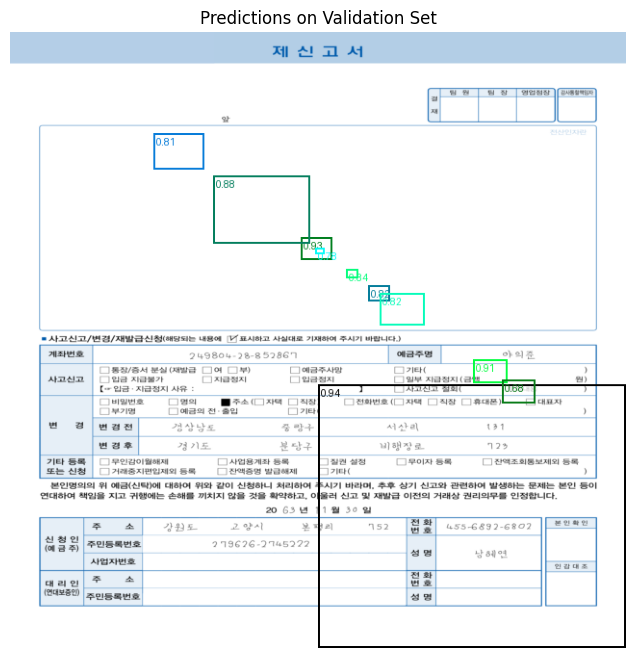

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import nms

# 모델 평가 모드
model.eval()

# ------------------------------
# 1. val_loader에서 이미지 하나 가져오기
# ------------------------------
with torch.no_grad():
    if len(val_ds) > 0:
        imgs, tgts = next(iter(val_loader))
    else:
        imgs, tgts = next(iter(train_loader))
    
    preds = model(imgs.to(DEVICE))

# ------------------------------
# 2. 예측 → 박스와 점수 디코딩
# ------------------------------
boxes, scores = decode_predictions(
    preds, conf_th=0.5, img_size=IMG_SIZE, S=S, iou_th=0.5
)

# ------------------------------
# 3. 시각화를 위한 전처리
# ------------------------------
img_uint8 = (imgs[0] * 255).to(torch.uint8)  # 0~255 정수형 변환
labels = [f"{s:.2f}" for s in scores]        # 점수를 라벨로 표시

# ------------------------------
# 4. bounding box 그리기
# ------------------------------
drawn = draw_bounding_boxes(img_uint8, boxes, labels=labels, width=2)

plt.figure(figsize=(8, 8))
plt.imshow(drawn.permute(1, 2, 0))
plt.axis("off")
plt.title("Predictions on Validation Set")
plt.show()
